In [1]:
!pip install deap

In [0]:
import operator, math, random, time
import numpy as np

from deap import algorithms, base, creator, tools, gp

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt
from tqdm import tqdm

In [0]:

# サンプルデータの生成
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=0, n_repeated=0,
                           n_clusters_per_class=8, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# LightGBM用の分割
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

# LightBGM

[1]	valid_0's auc: 0.743222
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.774293
[3]	valid_0's auc: 0.786269
[4]	valid_0's auc: 0.796968
[5]	valid_0's auc: 0.798784
[6]	valid_0's auc: 0.802183
[7]	valid_0's auc: 0.802674
[8]	valid_0's auc: 0.805887
[9]	valid_0's auc: 0.810216
[10]	valid_0's auc: 0.808829
[11]	valid_0's auc: 0.812117
[12]	valid_0's auc: 0.812388
[13]	valid_0's auc: 0.813328
[14]	valid_0's auc: 0.815966
[15]	valid_0's auc: 0.815584
[16]	valid_0's auc: 0.816796
[17]	valid_0's auc: 0.819553
[18]	valid_0's auc: 0.819432
[19]	valid_0's auc: 0.820362
[20]	valid_0's auc: 0.822502
[21]	valid_0's auc: 0.823933
[22]	valid_0's auc: 0.825941
[23]	valid_0's auc: 0.826346
[24]	valid_0's auc: 0.828636
[25]	valid_0's auc: 0.829256
[26]	valid_0's auc: 0.829943
[27]	valid_0's auc: 0.830962
[28]	valid_0's auc: 0.831575
[29]	valid_0's auc: 0.83256
[30]	valid_0's auc: 0.834183
[31]	valid_0's auc: 0.835503
[32]	valid_0's auc: 0.836211
[33]	valid_0's auc: 

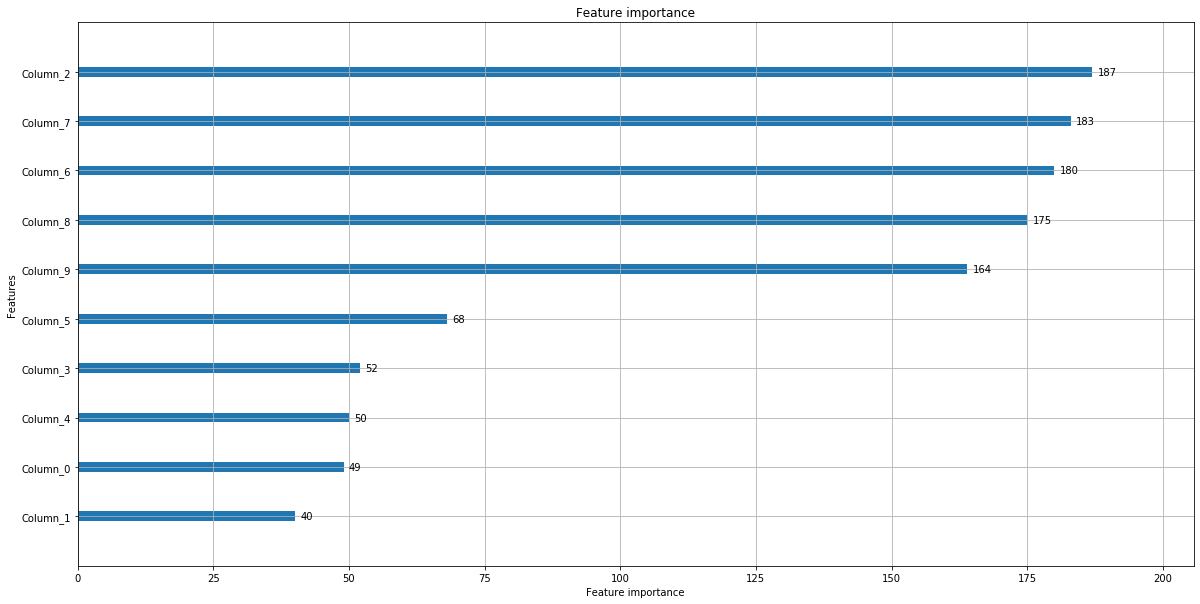

In [4]:
import lightgbm as lgb
import matplotlib.pyplot as plt

lgb_train = lgb.Dataset(X_train2, y_train2)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

lgbm_params = {
    'learning_rate': 0.1,
    'num_leaves': 8,
    'boosting_type' : 'gbdt',
    'reg_alpha' : 1,
    'reg_lambda' : 1,
    'objective': 'regression',
    'metric': 'auc',
    }

# 上記のパラメータでモデルを学習する
model = lgb.train(lgbm_params, lgb_train,
                  # モデルの評価用データを渡す
                  valid_sets=lgb_eval,
                  # 最大で 1000 ラウンドまで学習する
                  num_boost_round=1000,
                  # 10 ラウンド経過しても性能が向上しないときは学習を打ち切る
                  early_stopping_rounds=10)

# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(20, 10))
plt.show()

## testでの精度

In [5]:
from sklearn.metrics import roc_auc_score

# テストデータを予測する
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# auc を計算する
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.854653164840797


# Feature Generation by Genetic Programming

In [0]:
# ベースラインスコアの算出
clf = LogisticRegression(penalty="l2", C=1.0, solver='lbfgs')
base_train_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))
clf.fit(X_train, y_train)
base_test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

In [0]:
# 除算関数の定義
# 左項 / 右項で右項が0の場合1を代入する
def protectedDiv(left, right):
    eps = 1.0e-7
    tmp = np.zeros(len(left))
    tmp[np.abs(right) >= eps] = left[np.abs(right) >= eps] / right[np.abs(right) >= eps]
    tmp[np.abs(right) < eps] = 1.0
    return tmp

In [0]:
# 乱数シード
random.seed(123)

# 適合度を最大化するような木構造を個体として定義
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

In [0]:
# 初期値の計算
# 学習データの5-fold CVのAUCスコアを評価指標の初期値とする
n_features = X_train.shape[1]
clf = LogisticRegression(penalty="l2", C=1.0, solver='lbfgs')
prev_auc = np.mean(cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=5))

In [0]:
# メインループ
# resultsに特徴量数、学習データのAUCスコア（5-fold CV）、テストデータのAUCスコアを保持する
# exprsに生成された特徴量の表記を保持する
results = []
exprs = []

In [0]:
for i in tqdm(range(100)):
    # 構文木として利用可能な演算の定義
    pset = gp.PrimitiveSet("MAIN", n_features)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(np.cos, 1)
    pset.addPrimitive(np.sin, 1)
    pset.addPrimitive(np.tan, 1)

    # 関数のデフォルト値の設定
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    # 評価関数の設定
    # 新しく生成した変数を元の変数に加えて5-fold CVを求める
    def eval_genfeat(individual):
        func = toolbox.compile(expr=individual)
        features_train = [X_train[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        X_train_tmp = np.c_[X_train, new_feat_train]
        return np.mean(cross_val_score(clf, X_train_tmp, y_train, scoring="roc_auc", cv=5)),

    # 評価、選択、交叉、突然変異の設定
    # 選択はサイズ10のトーナメント方式、交叉は1点交叉、突然変異は深さ2のランダム構文木生成と定義
    toolbox.register("evaluate", eval_genfeat)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

    # 構文木の制約の設定
    # 交叉や突然変異で深さ5以上の木ができないようにする
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)) 

    # 世代ごとの個体とベスト解を保持するクラスの生成
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    # 統計量の表示設定
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # 進化の実行
    # 交叉確率50%、突然変異確率10%、10世代まで進化
    start_time = time.time()
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)
    end_time = time.time()

    # ベスト解とAUCの保持
    best_expr = hof[0]
    best_auc = mstats.compile(pop)["fitness"]["max"]

    # 5-fold CVのAUCスコアが前ステップのAUCを超えていた場合
    # 生成変数を学習、テストデータに追加し、ベストAUCを更新する
    if prev_auc < best_auc:
        # 生成変数の追加
        func = toolbox.compile(expr=best_expr)
        features_train = [X_train[:,i] for i in range(n_features)]
        features_test = [X_test[:,i] for i in range(n_features)]
        new_feat_train = func(*features_train)
        new_feat_test = func(*features_test)
        X_train = np.c_[X_train, new_feat_train]
        X_test = np.c_[X_test, new_feat_test]

        ### テストAUCの計算（プロット用）
        clf.fit(X_train, y_train)
        train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

        # ベストAUCの更新と特徴量数の加算
        prev_auc = best_auc
        n_features += 1

        # 表示と出力用データの保持
        print(n_features, best_auc, train_auc, test_auc, end_time - start_time)
        results.append([n_features, best_auc, train_auc, test_auc])
        exprs.append(best_expr)

        # 変数追加後の特徴量数が30を超えた場合break
        if n_features >= 30:
            break


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg    	gen	max	min	nevals	std    
0  	300   	0.739727	0  	0.745009	0.496447	300   	0.0192815	4.43333	0  	15 	2  	300   	2.67436
1  	171   	0.741601	1  	0.771254	0.575648	171   	0.00984611	4.20333	1  	14 	1  	171   	2.56684
2  	164   	0.744416	2  	0.771254	0.740664	164   	0.00571922	3.83   	2  	13 	2  	164   	2.4388 
3  	155   	0.75053 	3  	0.771254	0.740476	155   	0.0112218 	3.64   	3  	11 	1  	155   	1.70012
4  	161   	0.760386	4  	0.771254	0.740668	161   	0.0134681 	3.1    	4  	8  	1  	161   	0.7    
5  	174   	0.761982	5  	0.771254	0.740884	174   	0.0131455 	3.03333	5  	9  	1  	174   	0.687184
6  	168   	0.761796	6  	0.771254	0.740626	168   	0.0132079 	3.06   	6 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8  	143   	0.763653	8  	0.771254	0.74084 	143   	0.0124039 	3.15   	8  	9  	1  	143   	0.770822
9  	162   	0.763272	9  	0.771254	0.740781	162   	0.0126399 	3.09667	9  	9  	1  	162   	0.721565



  1%|          | 1/100 [04:11<6:55:09, 251.61s/it]

10 	158   	0.762038	10 	0.771254	0.740898	158   	0.0131758 	3.15333	10 	9  	1  	158   	0.826532
11 0.7712535452506797 0.77314622792813 0.7644447914664616 251.5718240737915


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg    	gen	max	min	nevals	std    
0  	300   	0.770111	0  	0.788777	0.553379	300   	0.0171858	4.16333	0  	15 	2  	300   	2.49332


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


1  	166   	0.772871	1  	0.788777	0.770499	166   	0.00388655	4.55667	1  	18 	1  	166   	2.98219
2  	156   	0.777875	2  	0.792023	0.770694	156   	0.00677463	4.58667	2  	15 	1  	156   	2.49182
3  	168   	0.7819  	3  	0.792023	0.770985	168   	0.00806214	3.93   	3  	11 	1  	168   	1.72774
4  	147   	0.784516	4  	0.792023	0.770985	147   	0.00834855	3.23   	4  	13 	1  	147   	0.925797


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5  	164   	0.785688	5  	0.792023	0.770663	164   	0.00927646	3.34   	5  	9  	1  	164   	0.806887


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


6  	174   	0.783662	6  	0.792023	0.770948	174   	0.0101082 	3.39   	6  	10 	1  	174   	0.940514
7  	170   	0.784676	7  	0.792023	0.770496	170   	0.00983802	3.40667	7  	9  	1  	170   	0.825402
8  	166   	0.785643	8  	0.792023	0.770975	166   	0.00951449	3.45   	8  	9  	1  	166   	1.06184 
9  	156   	0.785725	9  	0.792023	0.770384	156   	0.0095044 	3.4    	9  	9  	1  	156   	0.875595



  2%|▏         | 2/100 [09:04<7:11:21, 264.10s/it]

10 	171   	0.786544	10 	0.792023	0.77072 	171   	0.0091191 	3.4    	10 	8  	1  	171   	0.883176
12 0.7920230305436811 0.7937243473536757 0.7885734992632456 293.1820342540741


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg    	gen	max	min	nevals	std    
0  	300   	0.791425	0  	0.801016	0.581403	300   	0.0121898	4.22667	0  	14 	2  	300   	2.49706


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


1  	174   	0.792955	1  	0.801142	0.791445	174   	0.00206111	4.47333	1  	13 	2  	174   	2.2262 
2  	139   	0.795757	2  	0.802115	0.791328	139   	0.00335436	4.81333	2  	12 	1  	139   	2.28002


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


3  	153   	0.797829	3  	0.806208	0.79165 	153   	0.00400123	4.64333	3  	14 	1  	153   	2.59412


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


4  	149   	0.799342	4  	0.806208	0.791637	149   	0.00405508	4.83667	4  	14 	1  	149   	2.05669


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5  	185   	0.799168	5  	0.806208	0.791667	185   	0.00509381	6.19667	5  	13 	1  	185   	1.5203 
6  	178   	0.800829	6  	0.806208	0.791511	178   	0.00561266	5.64667	6  	14 	1  	178   	1.73258
7  	152   	0.801922	7  	0.806208	0.791734	152   	0.00573531	4.98   	7  	9  	1  	152   	1.10133


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8  	161   	0.801681	8  	0.806208	0.791578	161   	0.00594665	5.00667	8  	10 	1  	161   	1.10753


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


9  	166   	0.801463	9  	0.806208	0.791606	166   	0.00592294	5.16   	9  	10 	1  	166   	1.29141



  3%|▎         | 3/100 [14:08<7:26:20, 276.08s/it]

10 	139   	0.802268	10 	0.806208	0.791762	139   	0.00574047	5.09667	10 	10 	2  	139   	1.14338
13 0.8062084770687429 0.8081007672574166 0.8048271429944263 303.99703645706177


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg 	gen	max	min	nevals	std    
0  	300   	0.805543	0  	0.817581	0.584404	300   	0.0128325	4.13	0  	15 	2  	300   	2.56251


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

1  	162   	0.80722 	1  	0.817581	0.805754	162   	0.00252808	4.44333	1  	14 	2  	162   	2.40003


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


2  	172   	0.810298	2  	0.817581	0.805893	172   	0.00447089	4      	2  	15 	1  	172   	1.91137


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


3  	168   	0.813912	3  	0.817581	0.805858	168   	0.00515885	3.11333	3  	9  	1  	168   	0.721449


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


4  	178   	0.813922	4  	0.817581	0.805863	178   	0.00526376	3.13   	4  	9  	1  	178   	0.820427


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5  	166   	0.814304	5  	0.817845	0.80591 	166   	0.00511486	3.11667	5  	9  	1  	166   	0.723226
6  	155   	0.814466	6  	0.817845	0.805942	155   	0.00499467	3.16333	6  	8  	1  	155   	0.680678
7  	161   	0.814609	7  	0.817845	0.805895	161   	0.00492891	3.44667	7  	10 	1  	161   	1.01349 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

8  	137   	0.81471 	8  	0.817845	0.806011	137   	0.00486255	4.65667	8  	11 	3  	137   	1.27755 
9  	152   	0.814695	9  	0.817845	0.806011	152   	0.00483053	5.09333	9  	12 	3  	152   	1.13341 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

10 	168   	0.813602	10 	0.817845	0.80601 	168   	0.00523728	4.98   	10 	11 	1  	168   	1.17456 
14 0.817845431035075 0.819342304712374 0.8142808235633288 385.56166911125183


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                             fitness                             	                      size                     
   	      	-----------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max     	min     	nevals	std      	avg 	gen	max	min	nevals	std    
0  	300   	0.81676	0  	0.821883	0.501355	300   	0.0182449	4.06	0  	14 	2  	300   	2.51059


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

1  	169   	0.817258	1  	0.821888	0.509316	169   	0.0178372	4.41	1  	15 	1  	169   	2.59908


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

2  	160   	0.819627	2  	0.825757	0.817404	160   	0.00181561	4.88333	2  	11 	2  	160   	1.58631
3  	153   	0.821105	3  	0.825757	0.817408	153   	0.00181145	5.20333	3  	13 	1  	153   	1.34981


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


4  	175   	0.821305	4  	0.827172	0.817514	175   	0.0024512 	6.18667	4  	12 	1  	175   	1.87576


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


5  	180   	0.822571	5  	0.827887	0.817594	180   	0.00301226	7.44667	5  	15 	3  	180   	1.75893
6  	189   	0.823152	6  	0.827887	0.817548	189   	0.00331509	8.02667	6  	14 	1  	189   	1.68897
7  	172   	0.823892	7  	0.827947	0.817594	172   	0.00366061	9.05333	7  	16 	1  	172   	2.22047
8  	177   	0.825029	8  	0.827947	0.817594	177   	0.00378076	10.9433	8  	16 	1  	177   	1.97993


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


9  	172   	0.824957	9  	0.827947	0.817476	172   	0.00384517	11.3433	9  	16 	1  	172   	1.6908 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

10 	161   	0.824991	10 	0.827947	0.817431	161   	0.00388221	11.1033	10 	15 	1  	161   	1.66513
15 0.827947079421944 0.829180532877514 0.8216523720289577 468.34641003608704


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std        	avg    	gen	max	min	nevals	std    
0  	300   	0.827956	0  	0.830983	0.825398	300   	0.000410444	4.07667	0  	14 	2  	300   	2.58923


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

1  	150   	0.8284  	1  	0.832167	0.827465	150   	0.000713888	3.69333	1  	14 	1  	150   	2.23293
2  	132   	0.829234	2  	0.833026	0.827463	132   	0.00121485 	3.39   	2  	11 	1  	132   	1.48028
3  	164   	0.830073	3  	0.833026	0.827526	164   	0.00174913 	3.49333	3  	11 	1  	164   	1.65226


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

4  	164   	0.830785	4  	0.833026	0.827463	164   	0.00212213 	3.68667	4  	11 	1  	164   	1.62126


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

5  	180   	0.831513	5  	0.833026	0.827562	180   	0.0020901  	3.07333	5  	8  	1  	180   	0.726606


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

6  	161   	0.831685	6  	0.833026	0.827449	161   	0.00201677 	3.14   	6  	8  	1  	161   	0.832907


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

7  	191   	0.831532	7  	0.833026	0.826619	191   	0.00212327 	3.11667	7  	9  	1  	191   	0.695022


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

8  	178   	0.831351	8  	0.833026	0.827463	178   	0.0021351  	3.08   	8  	7  	1  	178   	0.583324


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


9  	158   	0.8316  	9  	0.833026	0.827642	158   	0.00210341 	3.09333	9  	8  	1  	158   	0.656726


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)

  6%|▌         | 6/100 [35:51<10:02:09, 384.36s/it]

10 	177   	0.831558	10 	0.833026	0.827414	177   	0.00208481 	3.12   	10 	8  	1  	177   	0.701617
16 0.8330264894160717 0.8342498720570943 0.8248806778140816 448.6182916164398


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std        	avg    	gen	max	min	nevals	std    
0  	300   	0.832958	0  	0.835411	0.825153	300   	0.000567214	3.93667	0  	13 	2  	300   	2.29187


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

1  	162   	0.833304	1  	0.838228	0.826888	162   	0.000775732	3.67   	1  	13 	1  	162   	2.38909


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

2  	191   	0.834   	2  	0.838774	0.832422	191   	0.00136685 	4.52667	2  	19 	1  	191   	3.59759


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

3  	152   	0.835256	3  	0.83922 	0.832328	152   	0.00180497 	6.03667	3  	19 	1  	152   	4.06144


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

4  	144   	0.836381	4  	0.83922 	0.832222	144   	0.00232548 	5.01333	4  	16 	1  	144   	3.02762


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

5  	168   	0.83662 	5  	0.83922 	0.832347	168   	0.0025432  	6.09667	5  	17 	1  	168   	2.89609


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

6  	168   	0.837324	6  	0.839708	0.832457	168   	0.00252469 	8.91333	6  	16 	1  	168   	3.3634 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


7  	141   	0.838122	7  	0.839708	0.832635	141   	0.00223594 	11.3467	7  	17 	1  	141   	2.06393


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8  	177   	0.837958	8  	0.839736	0.832848	177   	0.00243555 	13.2333	8  	23 	1  	177   	3.17368


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

9  	163   	0.838389	9  	0.839737	0.832561	163   	0.00240414 	15.38  	9  	22 	5  	163   	2.52763


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

10 	147   	0.838947	10 	0.839758	0.832599	147   	0.00188169 	16.2433	10 	22 	2  	147   	2.82208
17 0.8397575580363377 0.84115085112346 0.8321401114741497 485.2809329032898


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

   	      	                                  fitness                                  	                      size                     
   	      	---------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std        	avg    	gen	max	min	nevals	std    
0  	300   	0.839654	0  	0.841519	0.831024	300   	0.000688115	4.05333	0  	14 	2  	300   	2.45027


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

1  	176   	0.840009	1  	0.84582 	0.839223	176   	0.000564986	3.72333	1  	16 	1  	176   	2.05916


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

2  	149   	0.840581	2  	0.84582 	0.839105	149   	0.00102359 	4.09333	2  	9  	1  	149   	1.87028


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


3  	156   	0.841422	3  	0.84582 	0.839474	156   	0.00182648 	4.11667	3  	10 	1  	156   	2.05663


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

4  	167   	0.842585	4  	0.848547	0.839482	167   	0.00270188 	4.70667	4  	10 	1  	167   	1.42149


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

5  	156   	0.843437	5  	0.852241	0.839343	156   	0.00290777 	5.08333	5  	11 	1  	156   	1.28701


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

6  	159   	0.843763	6  	0.854728	0.839203	159   	0.00344327 	5.42333	6  	12 	1  	159   	1.45744


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

7  	175   	0.844909	7  	0.854728	0.839203	175   	0.00469872 	6.03333	7  	12 	1  	175   	1.58079


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

8  	171   	0.846411	8  	0.854728	0.839292	171   	0.00593657 	6.1    	8  	13 	1  	171   	1.64215


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

9  	182   	0.847445	9  	0.854728	0.839337	182   	0.00666584 	6.43   	9  	11 	1  	182   	1.43472
